# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = './Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [3]:
# Write your answer here

# Ebola Folder 
DATA_FOLDER_ebola = DATA_FOLDER + '/ebola'
# Directories in the folder
ebola_directories = os.listdir(DATA_FOLDER_ebola)
# Remove License File
del ebola_directories[ebola_directories.index('LICENSE')]

# Names of the columns which contain the total number of daily incidents
data_columns = {'liberia':['Date','Variable', 'National'],
                'sl': ['date','variable', 'National'],
                'guinea':['Date','Description', 'Totals']
               }

### Load All CSV Files Contained In One Folder
TODO : write the explanatory paragraph

In [4]:
# Loads the information relevant to deaths and cases within the csv files contained in the directory for a given country

def load_csv_files_into_dataframe(folder, country):
    country_folder = folder + '/'+ country +'_data'
    csv_files = os.listdir(country_folder)    
    
    all_data = pd.DataFrame()
    
    date = data_columns[country][0]
    description = data_columns[country][1]
    totals = data_columns[country][2]
    
    for i, file in enumerate(csv_files):
        
        daily_csv = pd.read_csv(country_folder + '/' +file)
        
        # Find columns containing death or case keywords
        motives  = daily_csv[description][daily_csv[description].str.contains("death|case|Death|Case")]
        # Create a dictionary with the date and country
        daily_dict = {'Date': file[:10], 'Country':country}
        # Add the motives with corresponding total / national values to the dictionary
        daily_dict.update(dict(zip(motives.tolist(), daily_csv[totals][motives.index].tolist())))
        # Append the dictionary to the dataframe
        all_data = all_data.append(daily_dict, ignore_index = True)
    all_data = all_data.apply(pd.to_numeric, errors = 'ignore')
    all_data.Date = pd.to_datetime(all_data.Date)
    all_data['Month']  = all_data.Date.dt.month
    all_data['Year']  = all_data.Date.dt.year
    #all_data.set_index(['Date','Country'], inplace = True)
    return all_data

### General Selection Process 
For each of the countries we pre-selected the columns which contained the keywords death or case. We observed the remaining columns and removed columns which contained to many NaN values. 
For both death and case we then plotted all the columns in cumulative form using cumsum for columns which were not already cumulative. This way it was possible to identify the columns which had the least missing and most coherent data. 

#### Functions to clean and interpolate the data

In [5]:
#Functions used to clean and interpolate the data
def interpolate_data(df, clean_df, category, k = 1):
    # Drop nan values
    temp_df = df[np.isfinite(df[category])]
    # Interpolate the data
    x = np.array(temp_df['Days since'].tolist())
    y = np.array(temp_df[category].tolist())
    f = interpolate.interp1d(x,y)
    xnew = np.array(clean_df['Days since'].tolist())
    x_max = np.max(x)
    xnew = xnew[xnew <= x_max]
    ynew = f(xnew)
    return xnew, ynew


def clean_and_interpolate(df, k = 1):
    # Create a Dataframe With All The Dates From Start To Finish
    start = np.min(df['Date'].tolist())
    stop =  np.max(df['Date'].tolist())
    clean_df = pd.DataFrame(pd.date_range(start, stop))
    clean_df.rename(columns={0:'Date'}, inplace = True)
    # Get the index of the days 
    clean_df['Days since'] = (clean_df['Date'] - clean_df['Date'][0]).dt.days
    df['Days since'] = (df['Date'] - df['Date'][0]).dt.days
    
    clean_df['Month']  = clean_df.Date.dt.month
    clean_df['Year']  = clean_df.Date.dt.year
    clean_df['Country']  = df['Country'][0]
    clean_df['Deaths'] = None
    clean_df['Cases'] = None
    # Store the new values in the clean data
    xnew, ynew = interpolate_data(df, clean_df, 'Deaths', k = 1)
    clean_df['Deaths'].iloc[xnew] = ynew 
    xnew, ynew = interpolate_data(df, clean_df, 'Cases', k = 1)
    clean_df['Cases'].iloc[xnew] = ynew 
    
    
    #Comparing the Interpolation to the real data
    plt.figure(figsize = (20,10))
    plt.subplot(121)
    plt.plot(clean_df['Days since'], clean_df['Deaths'], 'b')
    plt.plot(df['Days since'],df['Deaths'], 'ob')
    plt.title('Deaths Interpolation')
    plt.subplot(122)
    plt.plot(clean_df['Days since'], clean_df['Cases'], 'b')
    plt.plot(df['Days since'],df['Cases'], 'ob')
    plt.title('Cases Interpolation')
    plt.show()
    
    return clean_df


### Liberia Dataset

In [6]:
liberia_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'liberia')
liberia_data.dropna(thresh=2, axis = 1, inplace = True) #drops columns with just one value different from NaN

### Selecting the Most Relevant Columns For "Cases"

For Liberia, the columns used to compute the new cases will be:
    - New Case/s (Probable)
    - New Case/s (Suspected)
    - New Case/s (confirmed)
Our approach has been to sum all the data of these three columns and then compute the monthly average taking into account confirmed, probable and suspected cases. So we will give an upper limit for the average number of new cases. The lower limit would be given by only using the *"New case/s (confirmed)"* column.

We also added the column *"Total confirmed cases"* in the next dataframe to show why we decided not to use this column for the computation (reasons will be given later).

In [7]:
df_data_1 = pd.DataFrame({'Date': liberia_data.Date,
                     'Total confirmed cases': liberia_data['Total confirmed cases'],
                     'New Case/s (Probable)': liberia_data['New Case/s (Probable)'],
                     'New Case/s (Suspected)': liberia_data['New Case/s (Suspected)'],
                     'New case/s (confirmed)': liberia_data['New case/s (confirmed)'],
                     'Month': liberia_data['Month']})

We decided that we couldn't use the data from December for various reasons:
- 1) We discovered (or at least it's our guess) that from day 2014-12-04 untill the end the data in the *"New Case/s"* rows starts to be cummulative, while it should be new daily data.
- 2) The December data from the *"New Case/s (Probable)"* and *"New Case/s (Suspected)"* is misleading. It is a cumulative type of data but we can clearly see that it decreases, which is not possible.
- 3) The data of December of *"New case/s (confirmed)"* should be placed in the column *"Total confirmed cases"*, but then we wouldn't have any data of December for the column *"New case/s (confirmed)"*.

For the calculation of the averaged new cases per month we used the 3 *"New Case/s"* columns. Taking into account this and the previous reasons, we decided not to make the analysis of December data. Basically, we lack data and the data little data we have is misleading for this month.

In the next cell we print the December data so that you can understand why we made that decision.

In [8]:
df_data_1.tail(10)

,Date,Month,New Case/s (Probable),New Case/s (Suspected),New case/s (confirmed),Total confirmed cases
90,2014-11-30,11,NaN,NaN,10.0,2823.0
91,2014-12-01,12,9.0,25.0,1.0,2823.0
92,2014-12-02,12,10.0,18.0,9.0,2824.0
93,2014-12-03,12,NaN,NaN,NaN,2830.0
94,2014-12-04,12,1800.0,3054.0,2867.0,NaN
95,2014-12-05,12,1808.0,3056.0,2867.0,NaN
96,2014-12-06,12,1810.0,3056.0,2869.0,NaN
97,2014-12-07,12,1829.0,3067.0,2869.0,NaN
98,2014-12-08,12,1805.0,3054.0,2927.0,NaN
99,2014-12-09,12,1801.0,3050.0,2946.0,NaN


In [9]:
# The data of December is dropped with a query.
df_data_1 = df_data_1.query('Month < 12')

As said, we add up the data of the 3 useful columns. We use the *.cumsum()* function to convert the daily new cases data into cumulative new cases data.

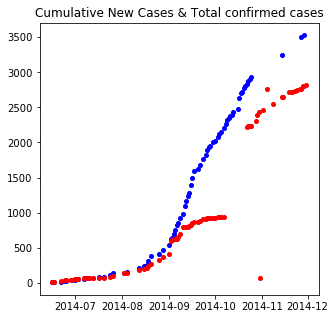

In [10]:
cum_data_new_cases = (df_data_1['New case/s (confirmed)'].cumsum() 
                      + df_data_1['New Case/s (Probable)'].cumsum()
                      + df_data_1['New Case/s (Suspected)'].cumsum())

plt.figure(figsize = (5,5))
plt.title('Cumulative New Cases & Total confirmed cases')
plt.plot(df_data_1['Date'], cum_data_new_cases, 'bo', markersize = 4)
plt.plot(df_data_1['Date'], df_data_1['Total confirmed cases'], 'ro', markersize = 4)

As we see, the *"Total confirmed cases"* (red-dotted curve) data doesn't fit well the expected behaviour of the ebola virus. In addition, we are missing data from October and it would be extremely rough to interpolate. For these reasons we didn't use this column to compute the calculations.

In contrast, the cumulative data (blue-dotted curve) fits more the expected behaviour of the virus, as it doesn't have drastic changes of the curvature.

### Selecting the Most Relevant Columns For "Deaths"

For the calculations we are going to use the following columns:
    - Total death/s in confirmed, probable, suspected cases
    - Total death/s in confirmed, \n probable, suspected cases
    
When combined, the other columns (from now on we will refer to them as verification columns, VC) will be used to verify that the *"Total death/s in confirmed, probable, suspected cases"* column is coherent. They will not be used for the calculation.

In [11]:
df_data_2 = pd.DataFrame({'Date': liberia_data.Date,
                     'Total death/s in confirmed cases': liberia_data['Total death/s in confirmed cases'],
                     'Total death/s in probable cases': liberia_data['Total death/s in probable cases'],
                     'Total death/s in suspected cases': liberia_data['Total death/s in suspected cases'],
                     'Total death/s in confirmed, probable, suspected cases': liberia_data['Total death/s in confirmed, probable, suspected cases'],
                     'Total death/s in confirmed, \n probable, suspected cases': liberia_data['Total death/s in confirmed, \n probable, suspected cases'],
                     'Month': liberia_data['Month']})

#### Plotting verification columns

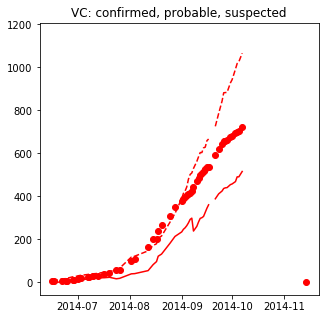

In [12]:
plt.figure(figsize = (5,5))
plt.title('VC: confirmed, probable, suspected')
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed cases'], 'r--')
plt.plot(df_data_2['Date'], df_data_2['Total death/s in probable cases'], 'ro')
plt.plot(df_data_2['Date'], df_data_2['Total death/s in suspected cases'], 'r')

We plot this figure to show the initial state of the VC data. Now we will clean it and then we will verify that the data we will use for the calculations is coherent with this data.

#### Modifying data to make it coherent
- need to shift the data of the continous red line after the drop (a line representing total data cannot decrease).
- need to clear the last data point of the red-dotted curve.

##### Continous red line correction

In [13]:
modified_column = df_data_2['Total death/s in suspected cases']
# Check where there is an drop (we get True values if there is a drop)
outlier = modified_column.diff()<0
# Get the index/s of the drops
outlier = outlier.index[outlier == True].tolist()
# We add the drop lenght to all the data that is after the drop
for outlier_index in outlier:
    correction = modified_column[outlier_index-1] - modified_column[outlier_index]
    modified_column.iloc[outlier_index:] = modified_column.iloc[outlier_index:] + correction
# Now the continous red line doesn't have any drops

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Deletion of the last data point in the red-dotted curve

In [14]:
#Spotting the index of the last data point
print(df_data_2['Total death/s in probable cases'].tail(25)) # it's the index 79
#Convert it to a NaN value
df_data_2['Total death/s in probable cases'].iloc[79] = np.nan

75    NaN
76    NaN
77    NaN
78    NaN
79    0.0
80    NaN
81    NaN
82    NaN
83    NaN
84    NaN
85    NaN
86    NaN
87    NaN
88    NaN
89    NaN
90    NaN
91    NaN
92    NaN
93    NaN
94    NaN
95    NaN
96    NaN
97    NaN
98    NaN
99    NaN
Name: Total death/s in probable cases, dtype: float64


/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Plot of the veirfication columns (after cleaning)

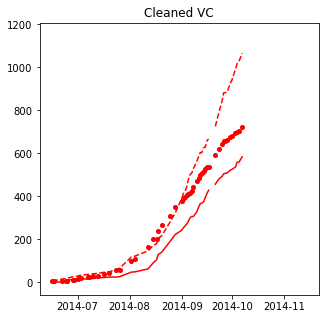

In [15]:
plt.figure(figsize = (5,5))
plt.title('Cleaned VC')
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed cases'], 'r--')
plt.plot(df_data_2['Date'], df_data_2['Total death/s in probable cases'], 'ro', markersize = 4)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in suspected cases'], 'r')

As we can see now the VC data has been cleaned.

#### Plot of all the data that we will use to compute the calculations + VC

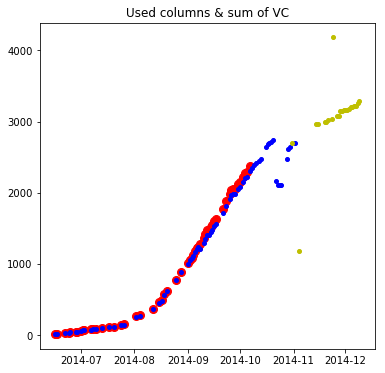

In [16]:
cum_data_deaths = (df_data_2['Total death/s in confirmed cases'] 
                   + df_data_2['Total death/s in probable cases'] 
                   + df_data_2['Total death/s in suspected cases'])

plt.figure(figsize = (6,6))
plt.title('Used columns & sum of VC')
plt.plot(df_data_2['Date'], cum_data_deaths, 'ro', markersize = 8)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed, probable, suspected cases'], 'bo', markersize = 4)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed, \n probable, suspected cases'], 'yo', markersize = 4)

We can clearly see why now we used verification columns. We can see that the data that we will use from *"Total death/s in confirmed, probable, suspected cases"* (blue) is coherent with the verification columns (red).

As we can choose between the blue and red curves because they represent the same, we will be using the blue curve as it has slightly more data.
We can also observe that the data from the *"Total death/s in confirmed, \n probable, suspected cases"* column (yellow) completes the data that was missing for the last months of the blue and red curves.

As we see we need to clean the outliers of the dotted-yellow curve (second datapoint and datapoint on the top) and also remove the last data points of the blue-dotted curve because it's misleading (the total number of deaths can't decrease and then go up again).

#### Cleaning outliers

#### Top data point & Second data point (yellow-dotted curve)

In [17]:
# CLEANING THE TOP DATA POINT

modified_column = df_data_2['Total death/s in confirmed, \n probable, suspected cases']
# Boolean series from which we will take the index of the outlier
outlier = modified_column.diff()<0
# Shift values in order to get the correct index
outlier = outlier.shift(-1)
# Getting the index of the outlier
outlier = outlier.index[outlier == True].tolist()
# Replacing it with NaN value
modified_column.iloc[outlier] = np.nan

# CLEANING THE SECOND DATA POINT

# Getting the index of the outlier
outlier_index = modified_column.iloc[modified_column.first_valid_index()+1:].first_valid_index()
# Replacing it with Nan
modified_column.iloc[outlier_index] = np.nan

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Clean last incoherent datapoints (blue-dotted line)

In [18]:
modified_column = df_data_2['Total death/s in confirmed, probable, suspected cases']
# Boolean series from which we will take the index of the outlier
bad_data = modified_column.diff()<0
# Get the index of the drop (we get a list because there are 2 drops, although we only see the big one in mid October)
outlier = bad_data[bad_data == True].index.tolist()
# Replace both outliers with NaN values
modified_column.iloc[outlier[0]] = np.nan
modified_column.iloc[outlier[1]-1:] = np.nan

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Plot of all the data that we will use to compute the calculations + verification columns (after cleaning)

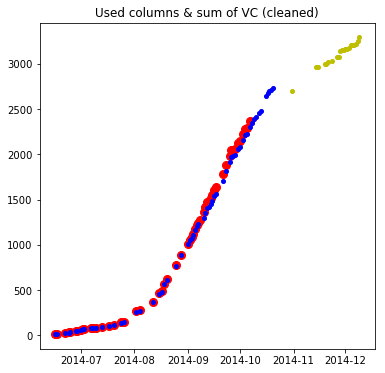

In [19]:
cum_data_deaths = (df_data_2['Total death/s in confirmed cases'] 
                   + df_data_2['Total death/s in probable cases'] 
                   + df_data_2['Total death/s in suspected cases'])

plt.figure(figsize = (6,6))
plt.title('Used columns & sum of VC (cleaned)')
plt.plot(df_data_2['Date'], cum_data_deaths, 'ro', markersize = 8)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed, probable, suspected cases'], 'bo', markersize = 4)
plt.plot(df_data_2['Date'], df_data_2['Total death/s in confirmed, \n probable, suspected cases'], 'yo', markersize = 4)

We see that the data has been cleaned. 

The final step will be to append the yellow line to the blue line and create the final dataframe with the deaths and new cases data from Liberia.

#### Liberia dataframe

In [20]:
# Merge the two columns
deaths = df_data_2['Total death/s in confirmed, probable, suspected cases'].add( \
                                df_data_2['Total death/s in confirmed, \n probable, suspected cases'], fill_value =  0.)
# Column for the new cases
new_cases = cum_data_new_cases

# Create the final Liberia df
df_liberia = pd.DataFrame({'Date': liberia_data.Date, 
                           'Deaths': deaths, 
                           'Cases': new_cases, 
                           'Year': liberia_data.Year,
                           'Country': liberia_data.Country,
                           'Month': liberia_data.Month})

#### Final Clean Liberia

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


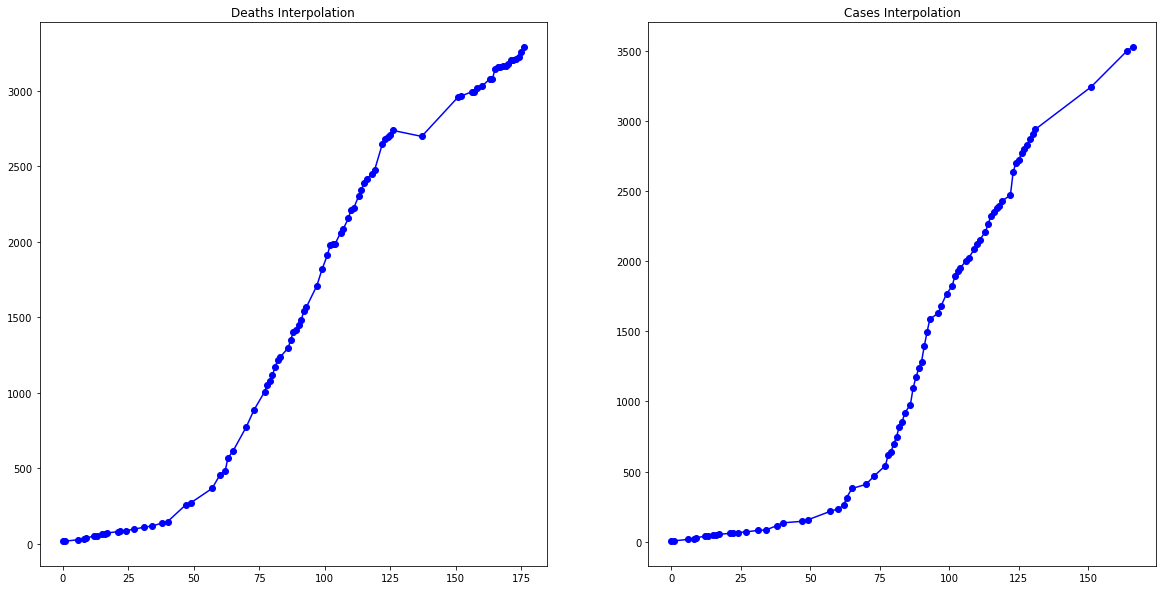

,,Days since,Month,Year,Deaths,Cases
Date,Country,,,,,
2014-06-16,liberia,0,6,2014,16.0,4
2014-06-17,liberia,1,6,2014,16.0,6
2014-06-18,liberia,2,6,2014,17.8,8
2014-06-19,liberia,3,6,2014,19.6,10
2014-06-20,liberia,4,6,2014,21.4,12


In [21]:
clean_liberia = clean_and_interpolate(df_liberia, k = 1)
clean_liberia.set_index(['Date','Country'], inplace = True)
clean_liberia.head()

### Guinea Dataset

In [22]:
guinea_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'guinea')
guinea_data.dropna(thresh = (len(guinea_data)//2), axis = 1, inplace = True)
guinea_data.head()

,Country,Date,New cases of confirmed,New cases of probables,New cases of suspects,Total cases of confirmed,Total cases of probables,Total cases of suspects,Total deaths (confirmed + probables + suspects),Total deaths of confirmed,...,Total new cases registered so far,New cases of confirmed among health workers,New deaths registered,New deaths registered among health workers,Total case of confirmed among health workers,Total deaths registered among health workers,Total number of hospitalized cases in CTE,Total suspected non-class cases,Month,Year
0,guinea,2014-08-04,4.0,0.0,5.0,351.0,133.0,11.0,363.0,228.0,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2014
1,guinea,2014-08-26,10.0,NaN,18.0,490.0,141.0,30.0,958.0,292.0,...,28.0,0.0,5.0,0.0,45.0,26.0,87.0,518.0,8,2014
2,guinea,2014-08-27,10.0,0.0,12.0,499.0,142.0,22.0,438.0,294.0,...,22.0,0.0,2.0,0.0,45.0,26.0,80.0,518.0,8,2014
3,guinea,2014-08-30,9.0,0.0,15.0,533.0,142.0,32.0,468.0,324.0,...,24.0,0.0,5.0,0.0,50.0,26.0,82.0,560.0,8,2014
4,guinea,2014-08-31,29.0,8.0,9.0,563.0,150.0,36.0,489.0,337.0,...,46.0,0.0,3.0,0.0,50.0,26.0,99.0,642.0,8,2014


#### Selecting the Most Relevant Columns For "Cases"

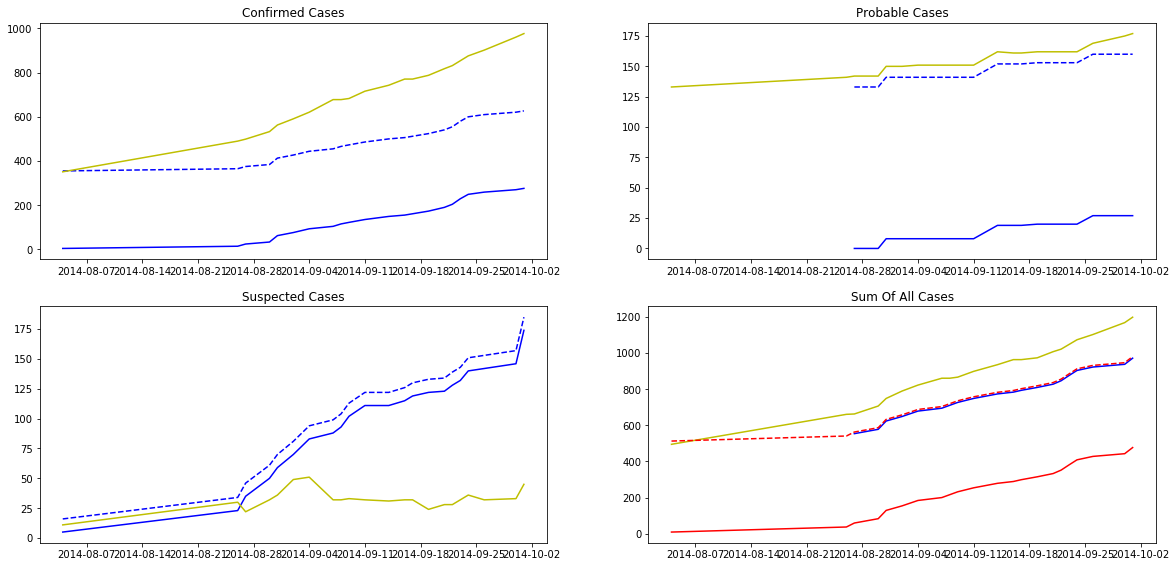

In [23]:
plt.figure(figsize = (20,20))
plt.subplot(421)
plt.plot(np.array(guinea_data['Date']), guinea_data['New cases of confirmed'].cumsum(), 'b') 
plt.plot(np.array(guinea_data['Date']), guinea_data['New cases of confirmed'].cumsum() + guinea_data['Total cases of confirmed'][0], '--b') 
plt.plot(np.array(guinea_data['Date']), guinea_data['Total cases of confirmed'], 'y') 
plt.title('Confirmed Cases')
plt.subplot(422)
plt.plot(np.array(guinea_data['Date']), guinea_data['New cases of probables'].cumsum(), 'b')
plt.plot(np.array(guinea_data['Date']), guinea_data['New cases of probables'].cumsum() + guinea_data['Total cases of probables'][0], '--b')
plt.plot(np.array(guinea_data['Date']), guinea_data['Total cases of probables'], 'y') 
plt.title('Probable Cases')
plt.subplot(423)
plt.plot(np.array(guinea_data['Date']), guinea_data['New cases of suspects'].cumsum(), 'b') 
plt.plot(np.array(guinea_data['Date']), guinea_data['New cases of suspects'].cumsum() +guinea_data['Total cases of suspects'][0], '--b') 
plt.plot(np.array(guinea_data['Date']), guinea_data['Total cases of suspects'], 'y') 
plt.title('Suspected Cases')
plt.subplot(424)
computed_cumsum = guinea_data['New cases of confirmed'].cumsum() + guinea_data['Total cases of confirmed'][0] + guinea_data['New cases of probables'].cumsum() + guinea_data['Total cases of probables'][0] + guinea_data['New cases of suspects'].cumsum() +guinea_data['Total cases of suspects'][0]
given_cumsum = guinea_data['Total cases of confirmed'] +guinea_data['Total cases of probables'] +guinea_data['Total cases of suspects']
plt.plot(guinea_data['Date'], computed_cumsum , 'b') 
plt.plot(guinea_data['Date'], given_cumsum, 'y') 
plt.plot(guinea_data['Date'], guinea_data['Total new cases registered so far'].cumsum() + computed_cumsum[0]  , '--r')
plt.plot(guinea_data['Date'], guinea_data['Total new cases registered so far'].cumsum(), 'r')
plt.title('Sum Of All Cases')

The yellow curves represent the cumulative data which was already provided. The blue curves represent the computation of the cumulative data from the daily incidents. The information is then shifted (dashed curves) based on the initial value of the cumulative data provided to take into account previous cases which were recoreded but not provided in the table. In the final plot (Sum of All Cases) we compare the sum of computed cumulative, the sum of the provided cumulative and the provided Total which we cumulated to obtain the plot. We noticed that the red curve followed the exact same trend as the blue curve. Shifting the curve up by the previous values (here from the sum of the provided cumulative data) we obtain a curve (dashed red) which corresponds exactly to what was computed. Therefore we assume that the red dashed line gives a correct estimation of the cases for Guinea. 

The issue with this is that there might redundancies between the probably, suspected and cumulative cases. There is no way of knowing how many probable or suspected cases are confirmed later on. The values we obtain are an upper limit of the total number of actual cases. The lower limit would only be given by the confirmed cases. 

In [24]:
# Total of all cases
guinea_data['Cases'] = guinea_data['Total new cases registered so far'].cumsum() + computed_cumsum[0]

#### Selecting the Most Relevant Columns For "Deaths"

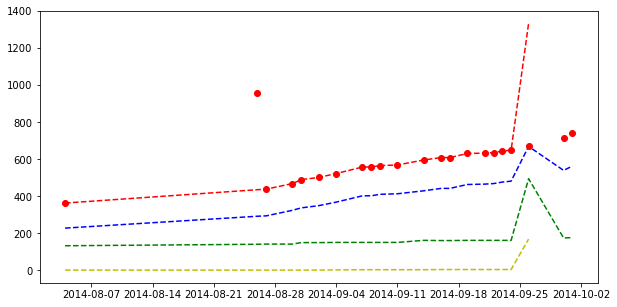

In [25]:
plt.figure(figsize = (10,5))
plt.plot(np.array(guinea_data['Date']), guinea_data['Total deaths of confirmed'], '--b') 
plt.plot(np.array(guinea_data['Date']), guinea_data['Total deaths of probables'], '--g') 
plt.plot(np.array(guinea_data['Date']), guinea_data['Total deaths of suspects'], '--y') 
plt.plot(np.array(guinea_data['Date']), guinea_data['Total deaths of suspects']+guinea_data['Total deaths of probables'] +guinea_data['Total deaths of confirmed'], '--r') 
plt.plot(np.array(guinea_data['Date']), guinea_data['Total deaths (confirmed + probables + suspects)'], 'or') 

The Total deaths provided is represented by the points in red. The computed total deaths is given by the dashed red curve (sum of the blue, green and yellow curves). The trend is quite similar at the start except for an outlyer in the provided total deaths. The compted total however seems to diverge strangely at the end. That is why we decided to keep the provided totals all the while replacing the outlyer around 2014-08-28 by the value computed in the sum.

Here the suspected cases are always equal to zero in the region of interest. The probable cases do not vary which is why we can assume that there no redundancy between this category and the confirmed deaths. Therefore the deaths can be given by the 'Total deaths (confirmed + probables + suspects)' column to which the suss-mentioned cleaning process will be applied.

In [26]:
guinea_data['Deaths'] = guinea_data['Total deaths (confirmed + probables + suspects)']
guinea_data['Totals'] = guinea_data['Total deaths of suspects']+guinea_data['Total deaths of probables'] +guinea_data['Total deaths of confirmed']
# Get the index of the outlyer
outlyer = guinea_data.Deaths.diff()<0
# Shift the index so that it corresponds to the problematic element
outlyer = outlyer.shift(-1)
outlyer = outlyer.index[outlyer == True].tolist()
# Replace the outlyer by none in the table
guinea_data['Deaths'].iloc[outlyer] = guinea_data['Totals'].iloc[outlyer]


/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Final Clean Data For Guinea

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


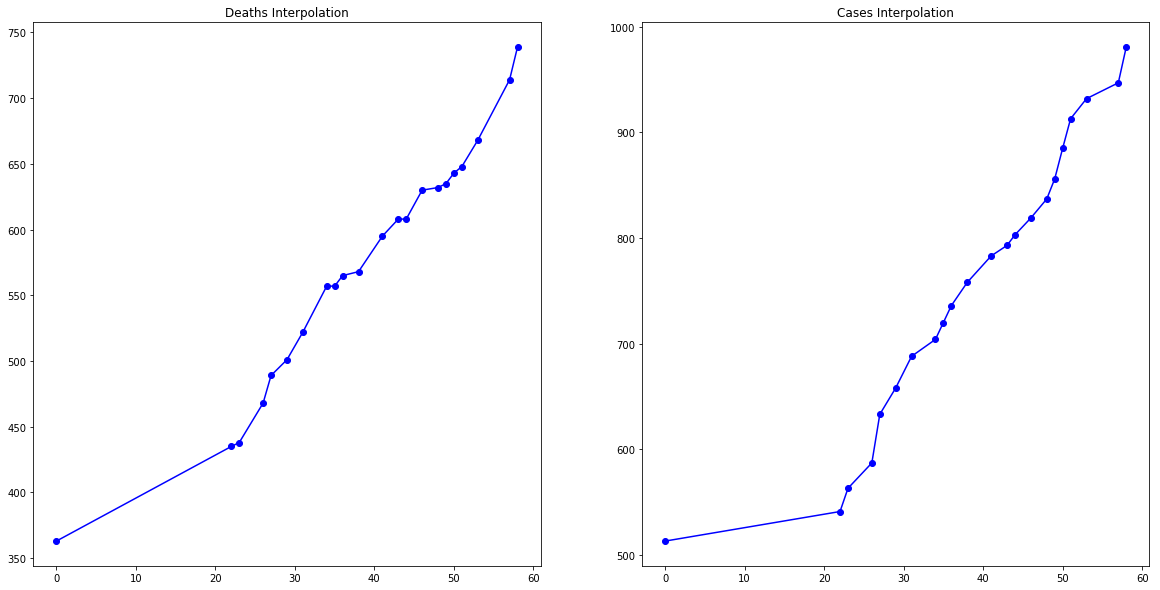

,,Days since,Month,Year,Deaths,Cases
Date,Country,,,,,
2014-08-04,guinea,0,8,2014,363.000000,513.000000
2014-08-05,guinea,1,8,2014,366.272727,514.272727
2014-08-06,guinea,2,8,2014,369.545455,515.545455
2014-08-07,guinea,3,8,2014,372.818182,516.818182
2014-08-08,guinea,4,8,2014,376.090909,518.090909


In [27]:
clean_guinea = clean_and_interpolate(guinea_data)
clean_guinea.set_index(['Date','Country'], inplace = True)
clean_guinea.head()

### Sierra Leone Dataset

In [28]:
sl_data = load_csv_files_into_dataframe(DATA_FOLDER_ebola,'sl')

# Clean the data : replace commas for numbers with points and convert back to float
sl_data.cum_noncase = sl_data.cum_noncase.astype(str)
sl_data.cum_noncase = sl_data.cum_noncase.apply(str.replace, args = (',', ''))
sl_data.cum_noncase = sl_data.cum_noncase.astype(float)
sl_data.new_noncase = sl_data.new_noncase.astype(float)

# remove columns with over half of the values which are NAN
sl_data.dropna(thresh = (len(sl_data)//2), axis = 1, inplace = True)
sl_data.head()

,Country,Date,cum_noncase,death_confirmed,death_probable,death_suspected,new_noncase,Month,Year
0,sl,2014-08-12,657.0,264.0,34.0,5.0,4.0,8,2014
1,sl,2014-08-13,680.0,273.0,34.0,5.0,13.0,8,2014
2,sl,2014-08-14,708.0,280.0,34.0,5.0,26.0,8,2014
3,sl,2014-08-15,726.0,287.0,34.0,5.0,15.0,8,2014
4,sl,2014-08-16,741.0,297.0,34.0,5.0,9.0,8,2014


#### Selecting the Most Relevant Columns For "Cases"

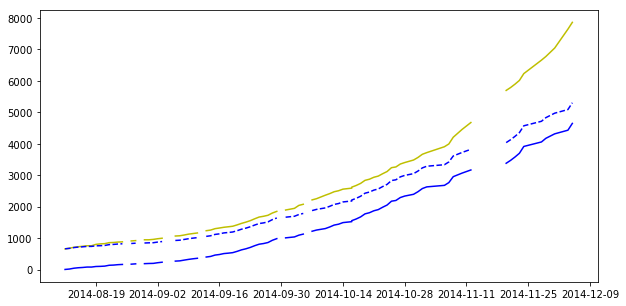

In [29]:
plt.figure(figsize = (10,5))
plt.plot(sl_data['Date'], sl_data['cum_noncase'], 'y')
plt.plot(sl_data['Date'], sl_data['new_noncase'].cumsum(), 'b')
plt.plot(sl_data['Date'], sl_data['new_noncase'].cumsum() +  sl_data['cum_noncase'][0], '--b')

Following the reasoning as previously the most coherent data for the new cases would be to keep the cumulative sum computed after shifting it to take into account previous values. 

In [30]:
sl_data['Cases'] = sl_data['new_noncase'].cumsum() +  sl_data['cum_noncase'][0]

#### Selecting the Most Relevant Columns For "Deaths"

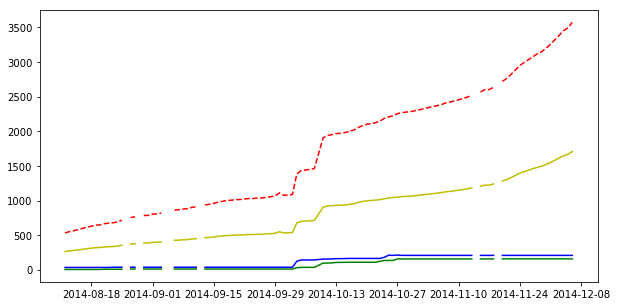

In [31]:
plt.figure(figsize = (10,5))
plt.plot(sl_data['Date'], sl_data['death_confirmed'], 'y')
plt.plot(sl_data['Date'], sl_data['death_probable'], 'b')
plt.plot(sl_data['Date'], sl_data['death_suspected'], 'g')
plt.plot(sl_data['Date'], sl_data['death_confirmed']+sl_data['death_suspected']+sl_data['death_confirmed'], 'r--')

Summing the three types of deaths leads to values which seem much too high for the total deaths. That is why in this case we decided that the deaths would be more correctly represented by the confirmed deaths column only. 

In [32]:
sl_data['Deaths'] = sl_data['death_confirmed']

#### Final Clean Data For Sierra Leone

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


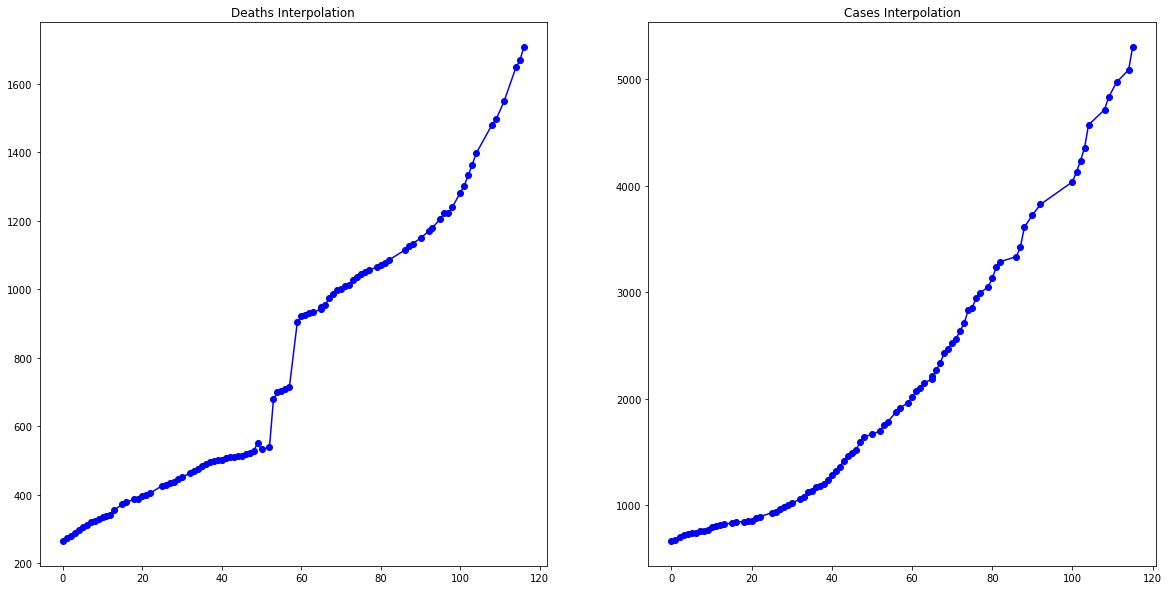

,,Days since,Month,Year,Deaths,Cases
Date,Country,,,,,
2014-08-12,sl,0,8,2014,264,661
2014-08-13,sl,1,8,2014,273,674
2014-08-14,sl,2,8,2014,280,700
2014-08-15,sl,3,8,2014,287,715
2014-08-16,sl,4,8,2014,297,724


In [33]:
clean_sl = clean_and_interpolate(sl_data, k = 1)
clean_sl.set_index(['Date','Country'], inplace = True)
clean_sl.head()

### Compute Monthly Average

Compute the daily incidents from the cumulative data. First create daily deaths and cases columns. Finally, Groupby country, year and month to compute monthly averages

In [34]:
all_countries = pd.concat([clean_sl, clean_guinea, clean_liberia])
all_countries.reset_index(inplace = True)
all_countries.Cases = all_countries.Cases.astype(float)
all_countries.Deaths = all_countries.Deaths.astype(float)

countries_list = ['guinea', 'liberia', 'sl']
for country in countries_list:
    all_countries.loc[all_countries.Country==country, 'Daily Deaths'] = all_countries.loc[all_countries.Country==country, 'Deaths'].diff()
    all_countries.loc[all_countries.Country==country, 'Daily Cases'] = all_countries.loc[all_countries.Country==country, 'Cases'].diff()

all_countries[['Country', 'Year','Month','Daily Cases','Daily Deaths']].groupby(['Country', 'Year','Month']).mean()

Daily Cases  Daily Deaths
Country Year Month                           
guinea  2014 8         4.444444      4.666667
             9        10.466667      7.500000
             10       34.000000     25.000000
liberia 2014 6         2.714286      2.785714
             7         3.221198      5.483871
             8        12.319124     24.169355
             9        49.241667     36.125000
             10       33.203226     20.612903
             11       17.127586     15.333333
             12             NaN     14.777778
sl      2014 8        10.000000      6.473684
             9        26.750000      5.433333
             10       47.725806     16.774194
             11       59.000000     15.083333
             12       80.600000     30.916667

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [35]:
# Write your answer here
DATA_FOLDER_microbiome = DATA_FOLDER + '/microbiome'

# Get all the files in the folder
microbiome_cvs_files = os.listdir(DATA_FOLDER_microbiome)
# Get the 9 first spreadsheets
RNA_seq_files = [x for x in microbiome_cvs_files if 'MID' in x]
# Get the last spreadsheet
metadata_file = [x for x in microbiome_cvs_files if x not in RNA_seq_files]

# Load the metadata into a dataframe
metadata_df = pd.read_excel((DATA_FOLDER_microbiome + '/' + metadata_file[0]))
metadata_columns = metadata_df.columns.values

# Create the dataframe
microbiome_data = pd.DataFrame(index = [])

# Load the 9 spreadsheets into one dataframe
for file in RNA_seq_files:
    # Load the xls file
    df = pd.read_excel(DATA_FOLDER_microbiome + '/' +file,header= None)
    # Get the name of the barcode for the given file
    Barcode_idx = file.replace('.xls','')
    # Get the metadata associated to the given barcode
    file_metadata = metadata_df[metadata_df['BARCODE'].str.contains(Barcode_idx)].values[0]
    
    # Save the metadata to the dataframe
    for c, col in enumerate(metadata_columns):
        df[col] = file_metadata[c]

    # Merge it with the whole dataframe
    microbiome_data = pd.concat([microbiome_data,df])

# Rename the columns
microbiome_data = microbiome_data.rename(columns={0:'FULL NAME', 1:'NUMBER'})
# Create a dataframe with the classes of microbes
microbiome_categories = microbiome_data['FULL NAME'].apply(lambda x: pd.Series(x.split(' ')))
classes = {i: "Class"+str(i) for i in range(8)}
microbiome_categories.rename(columns=classes,inplace=True)
# Concatenate the data
microbiome_data = pd.concat([microbiome_categories, microbiome_data], axis=1)

# Replace all nan values with unknown
microbiome_data = microbiome_data.replace(np.nan, 'unknown', regex=True)
# Index to have a unique classification
microbiome_data = microbiome_data.set_index(list(classes.values())+['GROUP', 'SAMPLE'])
print("Index is unique : " + str(microbiome_data.index.is_unique))

grouped_microbiome_data = microbiome_data.groupby(list(classes.values()))
microbiome_data.head()



Index is unique : True


FULL NAME  \
Class0  Class1          Class2            Class3            Class4             Class5       Class6  Class7  GROUP              SAMPLE                                                       
Archaea "Crenarchaeota" Thermoprotei      Desulfurococcales Desulfurococcaceae Ignisphaera  unknown unknown EXTRACTION CONTROL unknown  Archaea "Crenarchaeota" Thermoprotei Desulfuro...   
                                                            Pyrodictiaceae     Pyrolobus    unknown unknown EXTRACTION CONTROL unknown  Archaea "Crenarchaeota" Thermoprotei Desulfuro...   
                                          Sulfolobales      Sulfolobaceae      Stygiolobus  unknown unknown EXTRACTION CONTROL unknown  Archaea "Crenarchaeota" Thermoprotei Sulfoloba...   
                                          Thermoproteales   Thermofilaceae     Thermofilum  unknown unknown EXTRACTION CONTROL unknown  Archaea "Crenarchaeota" Thermoprotei Thermopro...   
        "Euryarchaeota" "Methanomicrobia" Methanocellales   Methanocellaceae   Methanocella unknown unknown EXTRACTION CONTROL unknown  Archaea "Euryarchaeota" "Methanomicrobia" Meth...   

                                                                                                                                        NUMBER  \
Class0  Class1          Class2            Class3            Class4             Class5       Class6  Class7  GROUP              SAMPLE            
Archaea "Crenarchaeota" Thermoprotei      Desulfurococcales Desulfurococcaceae Ignisphaera  unknown unknown EXTRACTION CONTROL unknown       7   
                                                            Pyrodictiaceae     Pyrolobus    unknown unknown EXTRACTION CONTROL unknown       2   
                                          Sulfolobales      Sulfolobaceae      Stygiolobus  unknown unknown EXTRACTION CONTROL unknown       3   
                                          Thermoproteales   Thermofilaceae     Thermofilum  unknown unknown EXTRACTION CONTROL unknown       3   
        "Euryarchaeota" "Methanomicrobia" Methanocellales   Methanocellaceae   Methanocella unknown unknown EXTRACTION CONTROL unknown       7   

                                                                                                                                       BARCODE  
Class0  Class1          Class2            Class3            Class4             Class5       Class6  Class7  GROUP              SAMPLE           
Archaea "Crenarchaeota" Thermoprotei      Desulfurococcales Desulfurococcaceae Ignisphaera  unknown unknown EXTRACTION CONTROL unknown    MID1  
                                                            Pyrodictiaceae     Pyrolobus    unknown unknown EXTRACTION CONTROL unknown    MID1  
                                          Sulfolobales      Sulfolobaceae      Stygiolobus  unknown unknown EXTRACTION CONTROL unknown    MID1  
                                          Thermoproteales   Thermofilaceae     Thermofilum  unknown unknown EXTRACTION CONTROL unknown    MID1  
        "Euryarchaeota" "Methanomicrobia" Methanocellales   Methanocellaceae   Methanocella unknown unknown EXTRACTION CONTROL unknown    MID1

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [36]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### Importing Seaborn for Color Palettes

In [37]:
import seaborn as sns

# set the default color palette
# try other options: 'Blues', sns.cubehelix_palette(8)
sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.5))

# Seaborn can also use a context for different purpose
# possible values are paper, notebook, talk, and poster
sns.set_context("notebook")

### Loading the Dataset

In [38]:
titanic_data = pd.read_excel(DATA_FOLDER+'/titanic.xls')

titanic_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [39]:
# Convert data to string
titanic_data['boat'] = titanic_data['boat'].astype(str)
titanic_data['ticket'] = titanic_data['ticket'].astype(str)
# Remove non integer caracters from string
test = titanic_data['ticket'].apply(lambda x: ''.join(c for c in x if c.isdigit()))
test = test.replace('', -1)
test = test.astype(int)
test = test.replace(-1, np.nan)
titanic_data['ticket'] = test

In [40]:
# Replace nan values with unknown
titanic_data['cabin'].replace(np.nan, 'unknown', inplace = True)
titanic_data['embarked'].replace(np.nan, 'unknown', inplace = True)
titanic_data['home.dest'].replace(np.nan, 'unknown', inplace = True)
titanic_data['boat'].replace(np.nan, 'unknown', inplace = True)

### 3.1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 


Get the min and max vals as well as the types of all attributes. 
Compute the range only if the type of the attribute is int or float

In [41]:
def get_attributes_description(df):
    # Get attribute description
    
    # Gather the types, min and max in list of dictionnaries
    dicts = []
    dicts.append(df.dtypes.to_dict())
    dicts.append(df.min(skipna = True).to_dict())
    dicts.append(df.max(skipna = True).to_dict())
    # Put all in one dictionary
    attributes = { k:[d[k] for d in dicts] for k in dicts[0]}
    description = pd.DataFrame.from_dict(attributes, orient = 'index')
    description.rename(columns={0:'Type', 1:'Minimum', 2:'Maximum'}, inplace=True)
    
    # Compte the range only if int or float
    description['Range'] = None
    condition = description.Type.tolist()
    cond_int = [True if 'i' in x.str else False for x in condition]
    cond_float = [True if 'f' in x.str else False for x in condition]
    condition = [a or b for a, b in zip(cond_int, cond_float)]
    max_vals = description.Maximum[condition]
    min_vals = description.Minimum[condition]
    description.Range[condition] = max_vals.subtract(min_vals)
    return description

titanic_description = get_attributes_description(titanic_data)
titanic_description


,Type,Minimum,Maximum,Range
pclass,int64,1,3,2
survived,int64,0,1,1
name,object,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon",None
sex,object,female,male,None
age,float64,0.1667,80,79.8333
sibsp,int64,0,8,8
parch,int64,0,9,9
ticket,float64,2,2.31013e+07,2.31013e+07
fare,float64,0,512.329,512.329
cabin,object,A10,unknown,None


Here we see that there are certain attributes with missing information which is given by inf in the columns. This will be adressed in the following sections

The attributes which can be defined as categorical are those which have predefined levels such as pclass (3), sex (2), cabin (187), embarked (3) and boat (28).

In [42]:
categorical_attributes = ['pclass', 'sex', 'cabin', 'embarked', 'boat']

categ_titanic = titanic_data.copy()

for attribute in categorical_attributes:
    attribute_cat = categ_titanic[attribute].unique().tolist() 
    categ_titanic[attribute] = categ_titanic[attribute].astype('category')
    #categ_titanic[attribute].cat.categories = attribute_cat 


### Checking For Abherrant Data Before Handling

In [43]:
print(categ_titanic.sex.value_counts())
print(categ_titanic.cabin.str[0].value_counts())
print(categ_titanic.pclass.value_counts())
print(categ_titanic.embarked.value_counts())
print(categ_titanic.boat.value_counts())
print(categ_titanic.parch.value_counts())
print(categ_titanic.pclass.value_counts())
print(categ_titanic.survived.value_counts())
print(categ_titanic.sibsp.value_counts())

male      843
female    466
Name: sex, dtype: int64
u    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin, dtype: int64
3    709
1    323
2    277
Name: pclass, dtype: int64
S          914
C          270
Q          123
unknown      2
Name: embarked, dtype: int64
nan        823
13          39
C           38
15          37
14          33
4           31
10          29
5           27
3           26
9           25
11          25
16          23
7           23
8           23
D           20
6           20
12          19
2           13
A           11
B            9
1            5
5 7          2
13 15        2
C D          2
5 9          1
8 10         1
15 16        1
13 15 B      1
Name: boat, dtype: int64
0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: parch, dtype: int64
3    709
1    323
2    277
Name: pclass, dtype: int64
0    809
1    500
Name: survived, dtype: int64
0    891
1    319
2     42
4     22
3

There are ages which are between 0 and 1 but this seems to correspond to the age in months / 12. This is why this data was left as is. The Survived column sould be either True or False. If the value was superior to 1 it was then set back to 1. 

In [44]:
# Cleaning the data of interest
categ_titanic['age'].loc[(categ_titanic.age < 0)] = np.nan
categ_titanic['cabin'].loc[(categ_titanic.cabin.str[0] == "T")] = "unknown"
categ_titanic['survived'].loc[(categ_titanic.survived > 1)] = 1
categ_titanic['home.dest'].fillna("unknown", inplace=True)
categ_titanic_description = get_attributes_description(categ_titanic)

print(categ_titanic_description)

               Type              Minimum                      Maximum  \
pclass     category                    1                            3   
survived      int64                    0                            1   
name         object  Abbing, Mr. Anthony  van Melkebeke, Mr. Philemon   
sex        category               female                         male   
age         float64               0.1667                           80   
sibsp         int64                    0                            8   
parch         int64                    0                            9   
ticket      float64                    2                  2.31013e+07   
fare        float64                    0                      512.329   
cabin      category                  A10                      unknown   
embarked   category                    C                      unknown   
boat       category                    1                          nan   
body        float64                    1           

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 3.2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 


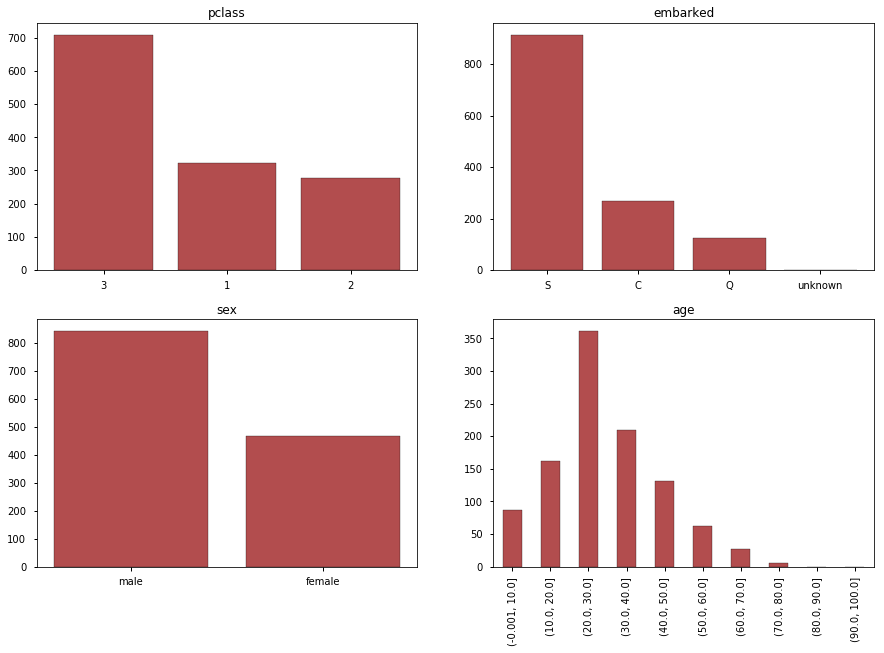

In [45]:
def bar_plot(df, category):
    counts = df[category].value_counts()
    plt.bar(range(len(counts)), counts.values, align='center', edgecolor="k")
    plt.xticks(range(len(counts)), counts.index.values, size='small')
    plt.title(category)
    
plt.figure(figsize = (15,10))
plt.subplot(221)
bar_plot(categ_titanic, 'pclass')
plt.subplot(222)
bar_plot(categ_titanic, 'embarked')
plt.subplot(223)
bar_plot(categ_titanic, 'sex')
plt.subplot(224)
bins= [i*10 for i in range(11)]
out = pd.cut(categ_titanic['age'], bins=bins, include_lowest=True)
out.value_counts(sort=False).plot.bar(edgecolor = 'k')
plt.title('age')
plt.show()  

### 3.3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

u    0.775401
C    0.071811
B    0.049656
D    0.035141
E    0.031322
A    0.016807
F    0.016043
G    0.003820
Name: cabin, dtype: float64


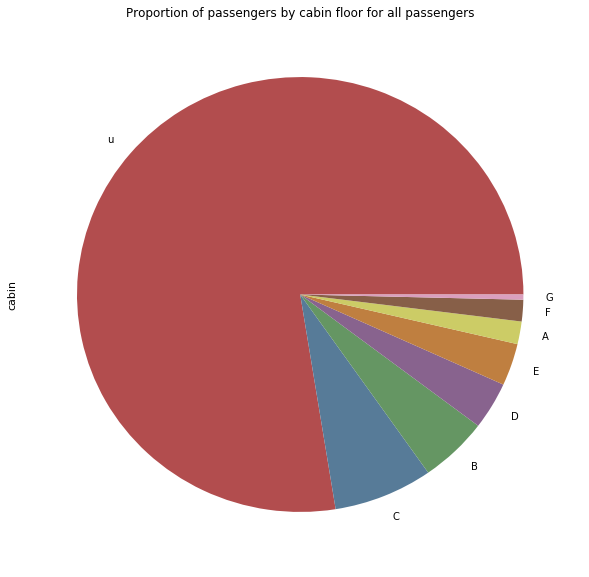

In [46]:
# Extract the cabin floors from the first letter of the cabins
cabin_floors = categ_titanic.cabin.str[0]

# Compute the total number of passengers
num_passengers = len(cabin_floors.tolist())
# Get the number of passengers per floor and compute the proportions
cabin_floors_proportions = cabin_floors.value_counts()/num_passengers
print(cabin_floors_proportions)

plt.figure(figsize = (10,10))
cabin_floors_proportions.plot.pie()
plt.title('Proportion of passengers by cabin floor for all passengers')

C    0.319728
B    0.221088
D    0.156463
E    0.139456
A    0.074830
F    0.071429
G    0.017007
Name: cabin, dtype: float64


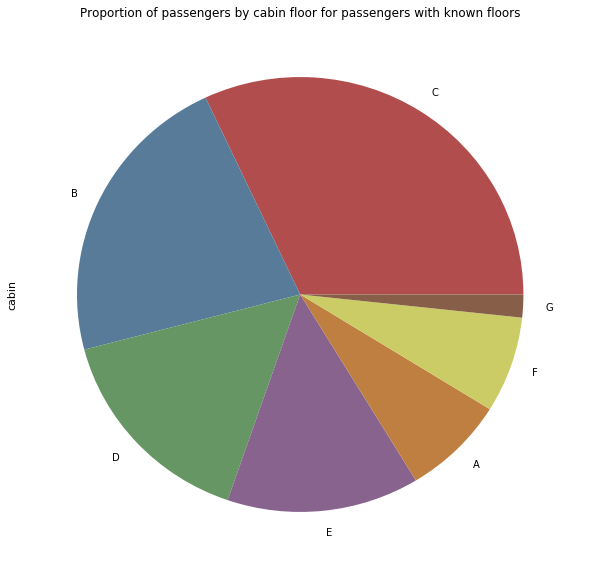

In [47]:
# Extract the cabin floors from the first letter of the cabins
cabin_floors = categ_titanic.cabin.str[0]
cabin_floors = cabin_floors[cabin_floors.str.contains("u|T") == False]

# Compute the total number of passengers
num_passengers = len(cabin_floors.tolist())
# Get the number of passengers per floor and compute the proportions
cabin_floors_proportions = cabin_floors.value_counts()/num_passengers
print(cabin_floors_proportions)

plt.figure(figsize = (10,10))
cabin_floors_proportions.plot.pie()
plt.title('Proportion of passengers by cabin floor for passengers with known floors')

### 3.4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

In [48]:
def compute_survival_proportions(df, by_category):
    # Groupe the passengers by travel class
    travel_classes = df.groupby(by_category)
    # Get the average of passengers that survived for each class
    survival_per_class = travel_classes[['survived']].mean()
    survival_per_class['died'] = 1-survival_per_class
    print(survival_per_class)
    return survival_per_class

        survived      died
pclass                    
1       0.619195  0.380805
2       0.429603  0.570397
3       0.255289  0.744711


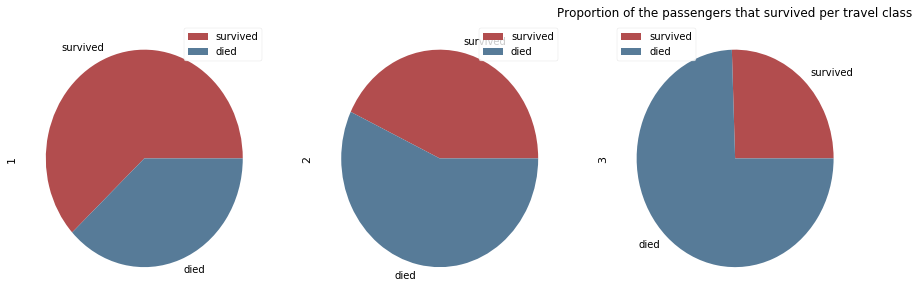

In [49]:
survival_class = compute_survival_proportions(categ_titanic, ['pclass'])
suvival_class_transpose = survival_class.transpose()

suvival_class_transpose.plot.pie(subplots = True, figsize = (15,5))
plt.title('Proportion of the passengers that survived per travel class')

### 3.5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

               survived      died
pclass sex                       
1      female  0.965278  0.034722
       male    0.340782  0.659218
2      female  0.886792  0.113208
       male    0.146199  0.853801
3      female  0.490741  0.509259
       male    0.152130  0.847870


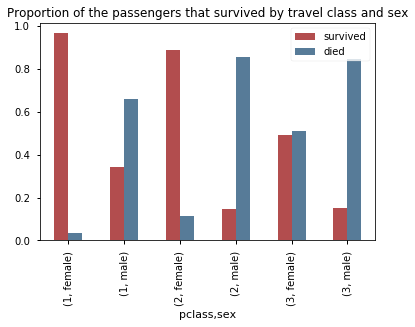

In [50]:
survival_class_sex = compute_survival_proportions(categ_titanic, ['pclass', 'sex'])
plt.figure(figsize = (10,10))
survival_class_sex.plot.bar()
plt.title('Proportion of the passengers that survived by travel class and sex')

### 3.6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [51]:
# Compute the median
median_age = categ_titanic['age'].median(skipna = True)
print("Number of passengers with the median age :",(categ_titanic['age'] == median_age).sum()) 

Number of passengers with the median age : 32


There are too many people with the median age. It is not possible to cut based on the median and obtain equal sized categories. 

In [52]:
# Sort by age
age_sorted = categ_titanic.sort_values(['age'])
# Keep rows where age is not nan
age_sorted = age_sorted[np.isfinite(age_sorted['age'])]
# Get the number of passengers for which the age is given
num_passengers = len(age_sorted['age'].tolist())
# Break up the dataframe into two equal proportions by age category : young and old
age_sorted.loc[:(num_passengers//2),'age_categ']= 'young'
age_sorted.loc[(num_passengers//2):,'age_categ']= 'old'
#----------------------------------------------------------------------------------------------------

# Plot the survival proportions
survival_age_class_sex = compute_survival_proportions(age_sorted, ['age_categ','pclass', 'sex'])
print("Index is unique: ",survival_age_class_sex.index.is_unique)

                         survived      died
age_categ pclass sex                       
old       1      female  0.963964  0.036036
                 male    0.333333  0.666667
          2      female  0.871429  0.128571
                 male    0.080645  0.919355
          3      female  0.467532  0.532468
                 male    0.157407  0.842593
young     1      female  0.954545  0.045455
                 male    0.538462  0.461538
          2      female  0.939394  0.060606
                 male    0.382353  0.617647
          3      female  0.480000  0.520000
                 male    0.187970  0.812030
Index is unique:  True
